# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import seaborn as sns
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage import exposure
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4,DenseNet121,ResNet50,MobileNetV3Small
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

2024-04-26 21:27:31.400498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 21:27:31.400600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 21:27:31.531286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the Data

In [2]:
dir_names = ["No_DR", "Mild", "Moderate", "Proliferate_DR", "Severe"]
images=[]
labels=[]

In [3]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

In [4]:
for i, dir_name in enumerate(dir_names):
    os.chdir('./'+dir_name)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            labels.append(i)
    os.chdir('../')

<Axes: ylabel='count'>

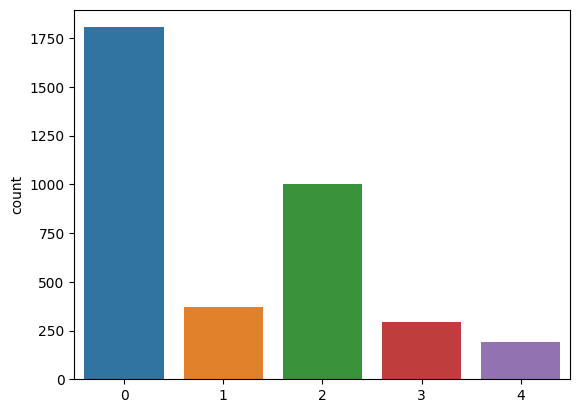

In [5]:
sns.countplot(x=labels)

In [6]:
(np.array(labels)==4).sum()

193

In [7]:
os.chdir('/kaggle/input/diabetic-retinopathy-resized-arranged')

# Combining two Datasets

In [8]:
max_images_per_label = 500
for i, _ in enumerate(dir_names):
    os.chdir('./'+f'{i}')
    imgs_names = os.listdir()
    count = labels.count(dir_names)
    for img_name in imgs_names:
        if count < max_images_per_label:
            with Image.open(img_name) as image:
                image = np.array(image)
                images.append(image)
                labels.append(i)
                count += 1
    os.chdir('../')

<Axes: ylabel='count'>

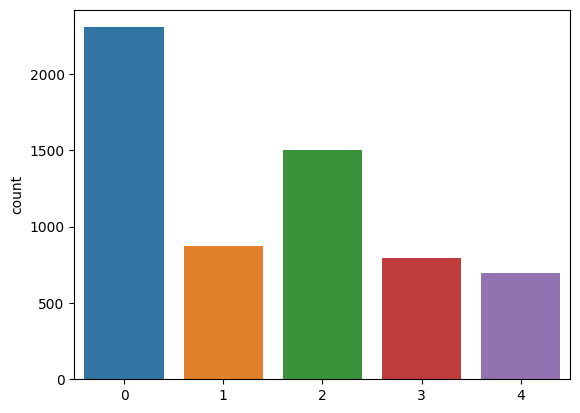

In [9]:
sns.countplot(x=labels)

In [10]:
(np.array(labels)==4).sum()

693

# Balancing Data

In [11]:
threshold_per_class = 700
filtered_images = []
filtered_labels = []
class_counts = {label: 0 for label in set(labels)}
for image, label in zip(images, labels):
    if class_counts[label] < threshold_per_class:
        filtered_images.append(image)
        filtered_labels.append(label)
        class_counts[label] += 1

<Axes: ylabel='count'>

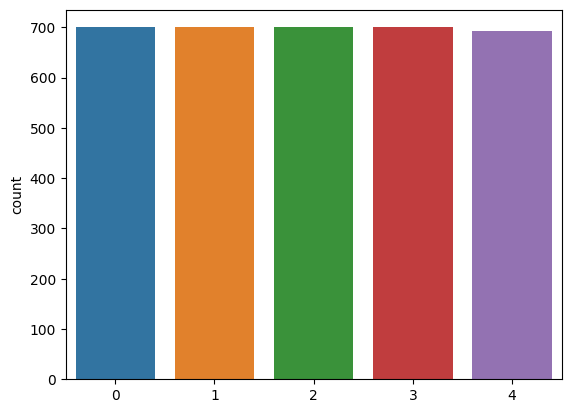

In [12]:
sns.countplot(x=filtered_labels)

In [13]:
len(filtered_images),len(filtered_labels)

(3493, 3493)

# Pre-Processing

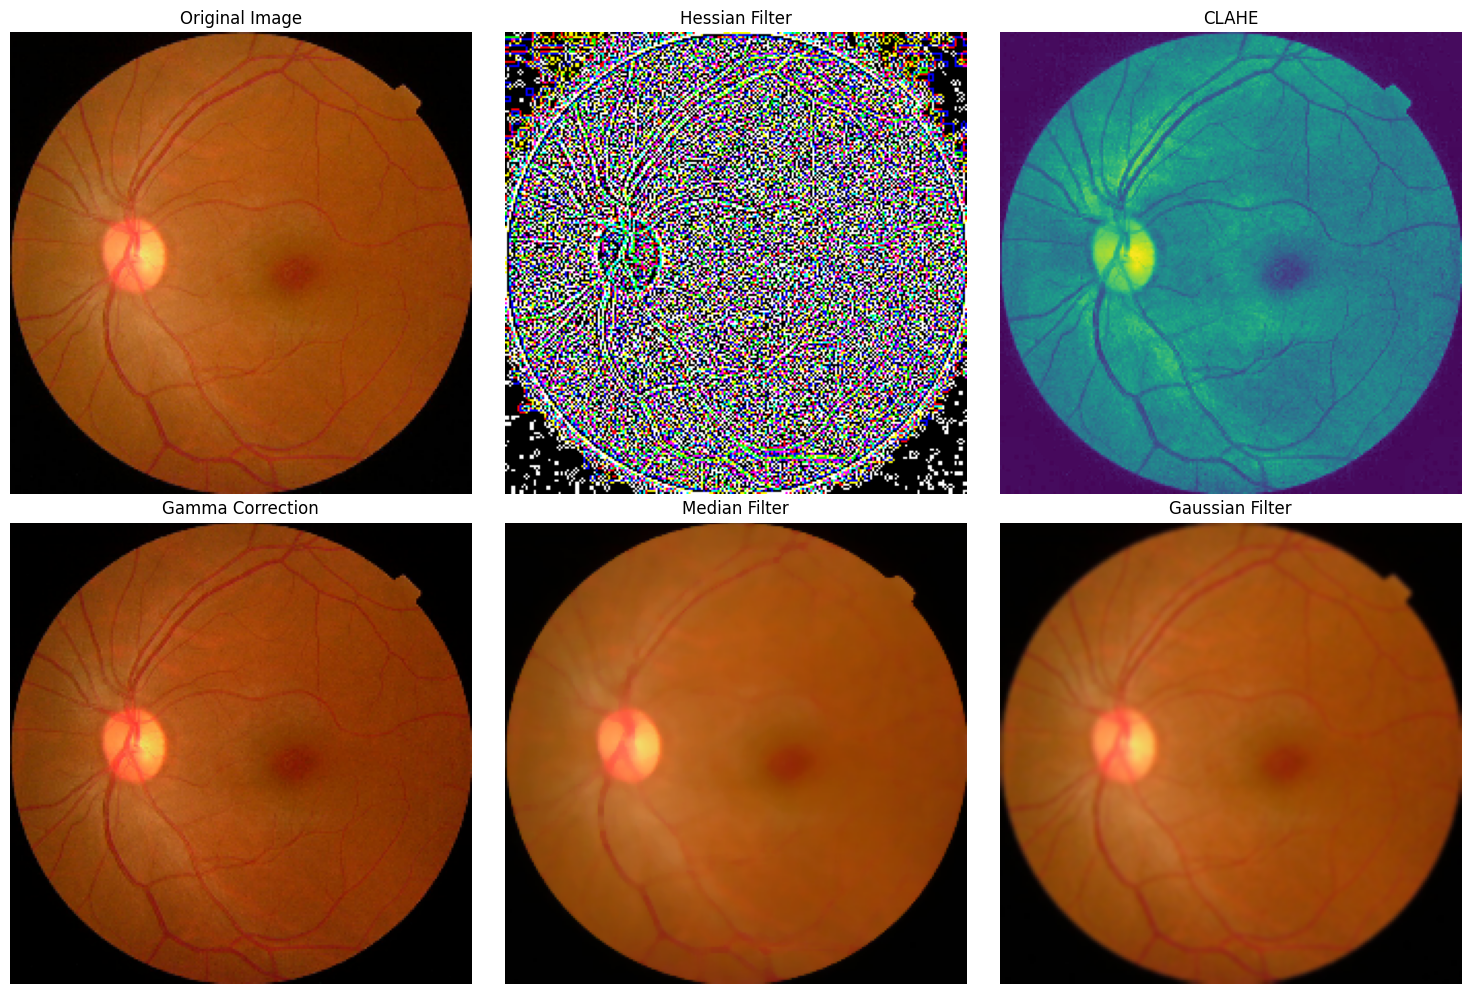

In [14]:
img_rgb=filtered_images[260]
processing_techniques = [
    ('Original Image', img_rgb),
    ('Hessian Filter', cv2.Laplacian(img_rgb, cv2.CV_64F)),
    ('CLAHE', cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))),
    ('Gamma Correction', exposure.adjust_gamma(img_rgb, gamma=1.2)),
    ('Median Filter', cv2.medianBlur(img_rgb, 5)),  # Applying Median filter with kernel size 5x5
    ('Gaussian Filter', cv2.GaussianBlur(img_rgb, (5, 5), 0))  # Applying Gaussian filter with kernel size 5x5
]
plt.figure(figsize=(15, 10))
for i, (title, processed_image) in enumerate(processing_techniques, start=1):
    plt.subplot(2, 3, i)
    plt.imshow(processed_image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    processed_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return processed_image

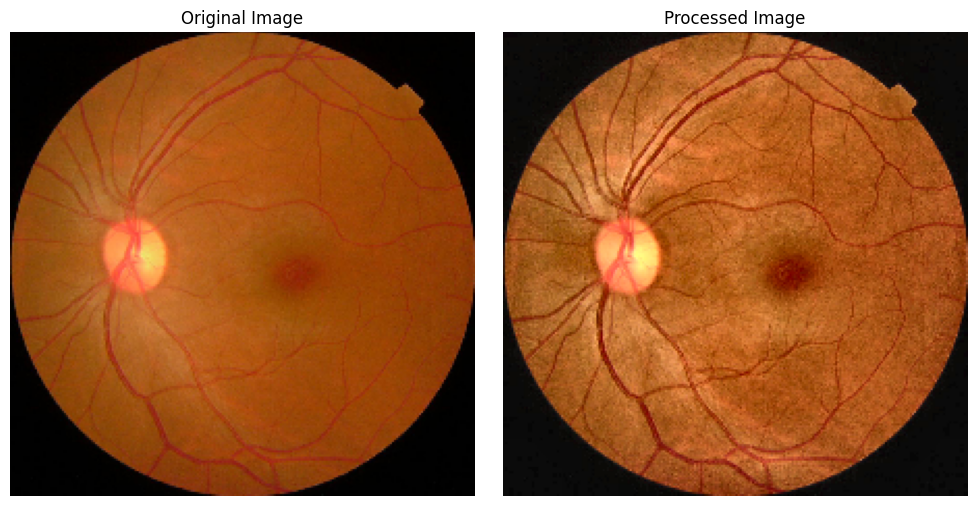

In [16]:
image_to_process = [(img_rgb, 'Original Image'), (preprocess_image(img_rgb), 'Processed Image')]
plt.figure(figsize=(10, 5))
for i, (image, title) in enumerate(image_to_process, start=1):
    plt.subplot(1, 2, i)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
preprocessed_images = [preprocess_image(img) for img in filtered_images]
preprocessed_images_resized = [Image.fromarray(img).resize((224, 224)) for img in preprocessed_images]
preprocessed_images_array = np.array([np.array(img) for img in preprocessed_images_resized])

In [18]:
filtered_labels = np.array(filtered_labels)
shuffled_indices = np.random.permutation(len(filtered_labels))
shuffled_preprocessed_images = preprocessed_images_array[shuffled_indices]
shuffled_filtered_labels = filtered_labels[shuffled_indices]

# Data Augmentation

In [19]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-10, 10)), 
    iaa.Affine(scale=(0.8, 1.2)) 
])

In [20]:
augmented_images = []
augmented_labels = []

In [21]:
for image, label in zip(shuffled_preprocessed_images, shuffled_filtered_labels):
    augmented_image = seq(image=image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [22]:
len(augmented_labels)

3493

In [23]:
final_images = np.concatenate((shuffled_preprocessed_images, augmented_images), axis=0)
final_labels = np.concatenate((shuffled_filtered_labels, augmented_labels), axis=0)
shuffled_indices = np.random.permutation(len(final_labels))
final_images = final_images[shuffled_indices]
final_labels = final_labels[shuffled_indices]

In [24]:
len(final_images)

6986

<Axes: ylabel='count'>

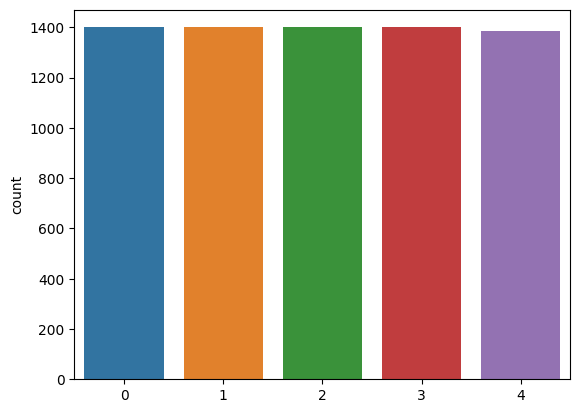

In [25]:
sns.countplot(x=final_labels)

In [26]:
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + f'{labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

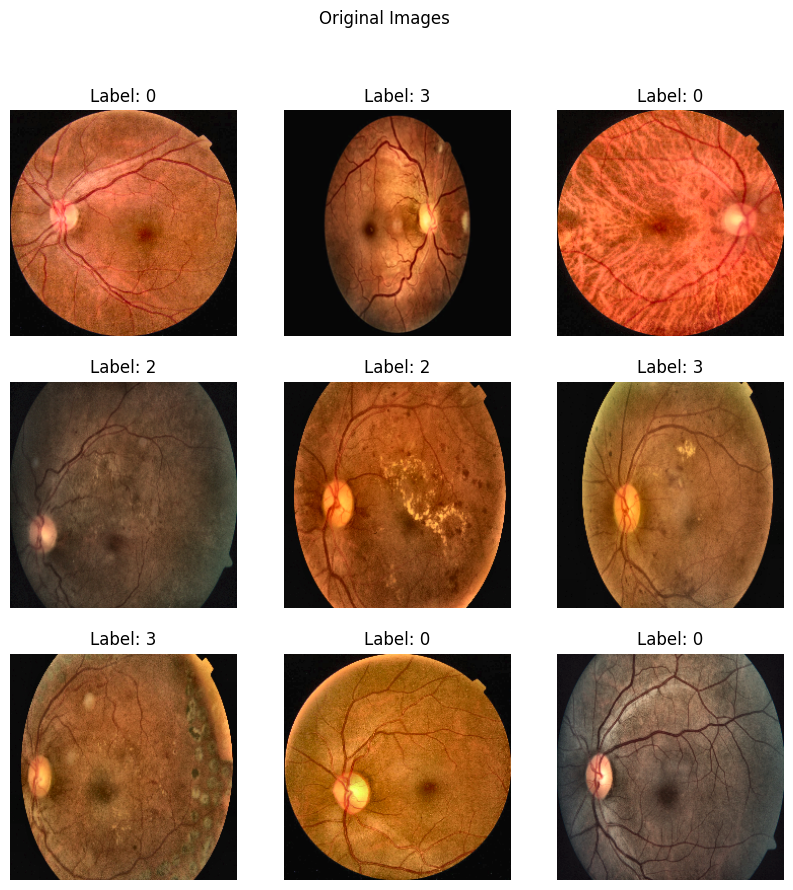

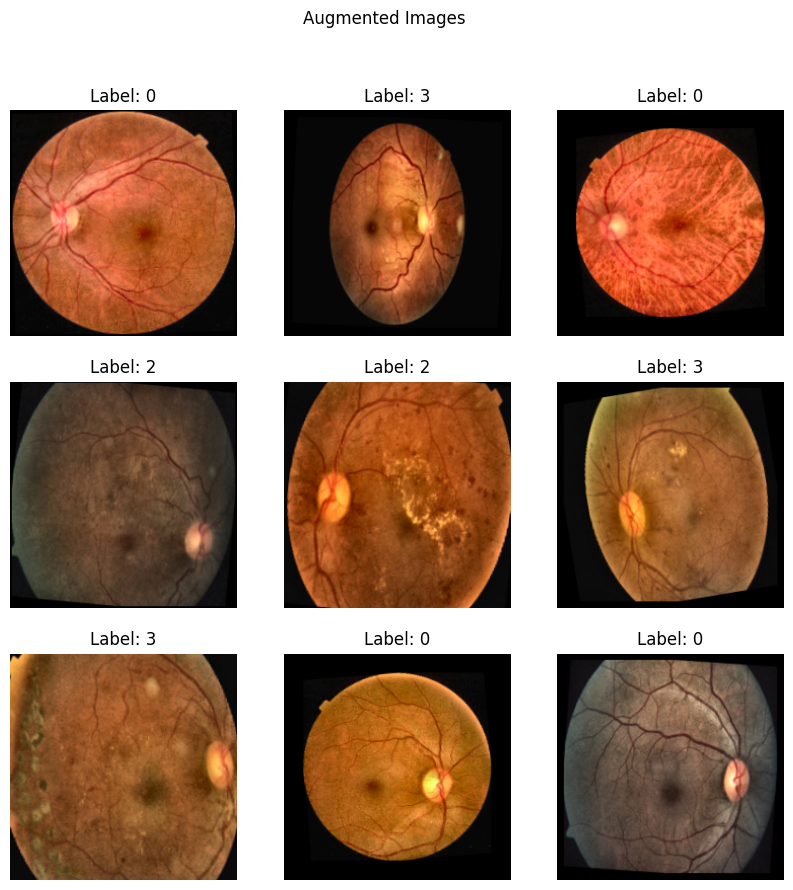

In [27]:
plot_images(shuffled_preprocessed_images[:9],shuffled_filtered_labels[:9], title='Original Images')
plot_images(augmented_images[:9], augmented_labels[:9], title='Augmented Images')

# Splitting the Data

In [28]:
x_train,x_test,y_train,y_test=train_test_split(final_images,final_labels,test_size=.2,stratify=final_labels,random_state=404)

# Transfer Learning Models

In [48]:
def build_model(pre_trained):
    x = pre_trained.output
    x = layers.Flatten()(x)  
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=pre_trained.input, outputs=predictions)    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# EfficientNetB4

In [30]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [31]:
model=build_model(base_model)

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

In [33]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/100


I0000 00:00:1714167419.746847     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714167419.859702     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2572 - loss: 3.0248   

W0000 00:00:1714167521.780039     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.2574 - loss: 3.0257 - val_accuracy: 0.2804 - val_loss: 4.4191 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.3115 - loss: 2.9420 - val_accuracy: 0.3999 - val_loss: 2.5430 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.3615 - loss: 2.5711 - val_accuracy: 0.5179 - val_loss: 2.0626 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.4100 - loss: 2.2669 - val_accuracy: 0.5358 - val_loss: 1.9115 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.4515 - loss: 2.0718 - val_accuracy: 0.5329 - val_loss: 1.7963 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.4834 - loss: 1.9314 - val_accuracy: 0.5536 - val_loss: 1.6549 - learning_rate: 0.0010
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.5131 - loss: 1.7953 - 

In [34]:
models=['EfficientNetB4','DenseNet','ResNet','VGG16']
accuracies=[]
cms=[]
histories=[]
trained_models=[]

In [35]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 402ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.6847 - loss: 1.0404


In [38]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# DenseNet 121

In [39]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [40]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 113s 194ms/step - accuracy: 0.2472 - loss: 2.6218 - val_accuracy: 0.3605 - val_loss: 2.0146 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3527 - loss: 2.1332 - val_accuracy: 0.4664 - val_loss: 1.7952 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4015 - loss: 1.8948 - val_accuracy: 0.4700 - val_loss: 1.6330 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4419 - loss: 1.7202 - val_accuracy: 0.4921 - val_loss: 1.5320 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4699 - loss: 1.6326 - val_accuracy: 0.4893 - val_loss: 1.5585 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4700 - loss: 1.6580 - val_accuracy: 0.4957 - val_loss: 1.4428 - learning_rate: 0.0010
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4808 -

In [41]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 461ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.6269 - loss: 0.9651


# ResNet 50

In [44]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [45]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [46]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2372 - loss: 3.0581

W0000 00:00:1714169680.786112     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


350/350 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.2373 - loss: 3.0577 - val_accuracy: 0.4034 - val_loss: 2.3174 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.3304 - loss: 2.4098 - val_accuracy: 0.5143 - val_loss: 1.8581 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4229 - loss: 2.0215 - val_accuracy: 0.5651 - val_loss: 1.5673 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4865 - loss: 1.7251 - val_accuracy: 0.5665 - val_loss: 1.4861 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.5313 - loss: 1.5700 - val_accuracy: 0.6001 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.5519 - loss: 1.5338 - val_accuracy: 0.6409 - val_loss: 1.3053 - learning_rate: 0.0010
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.5678 - loss: 1.439

In [47]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7465 - loss: 0.8531


# MobileNetV3Small

In [50]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=build_model(base_model)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [51]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 640ms/step - accuracy: 0.2570 - loss: 2.8232 - val_accuracy: 0.3319 - val_loss: 3.1552 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3320 - loss: 2.4357 - val_accuracy: 0.4728 - val_loss: 1.9733 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4064 - loss: 2.1447 - val_accuracy: 0.5551 - val_loss: 1.7292 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4550 - loss: 1.9635 - val_accuracy: 0.5715 - val_loss: 1.6034 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4855 - loss: 1.8230 - val_accuracy: 0.5923 - val_loss: 1.5002 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5313 - loss: 1.6895 - val_accuracy: 0.6159 - val_loss: 1.4377 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5573 - loss: 1.5704 - val_a

In [52]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6787 - loss: 1.1502


# Evaluating the Models

In [53]:
models_names=['EfficientNetB4','DenseNet 121','ResNet 50','MobileNetV3 Small']
data = {'Model': models_names, 'Accuracy': accuracies}
df = pd.DataFrame(data)
df.head()

Model  Accuracy
0     EfficientNetB4  0.696710
1       DenseNet 121  0.648069
2          ResNet 50  0.746781
3  MobileNetV3 Small  0.688841

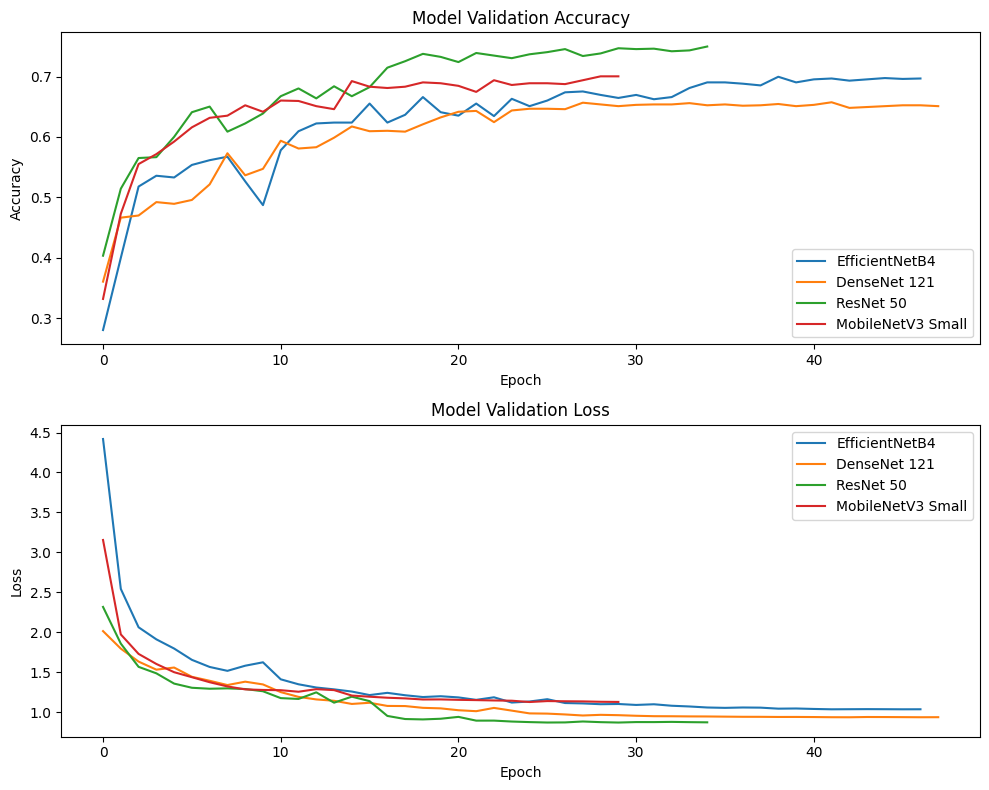

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for history, model_name in zip(histories, models_names):
    axs[0].plot(history.history['val_accuracy'], label=model_name)
    axs[0].set_title('Model Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[1].plot(history.history['val_loss'], label=model_name  )
    axs[1].set_title('Model Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

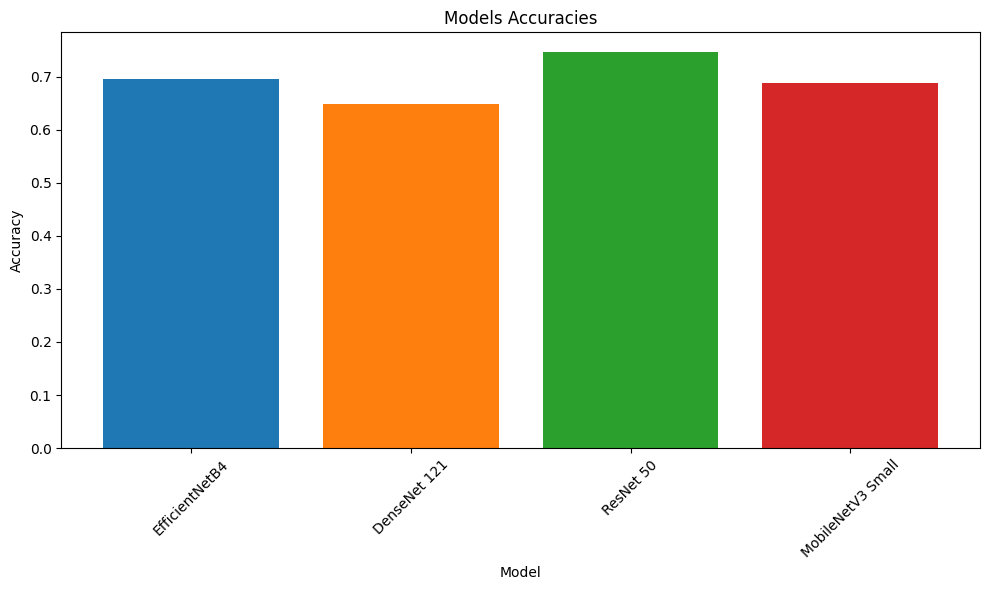

In [57]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Models Accuracies')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

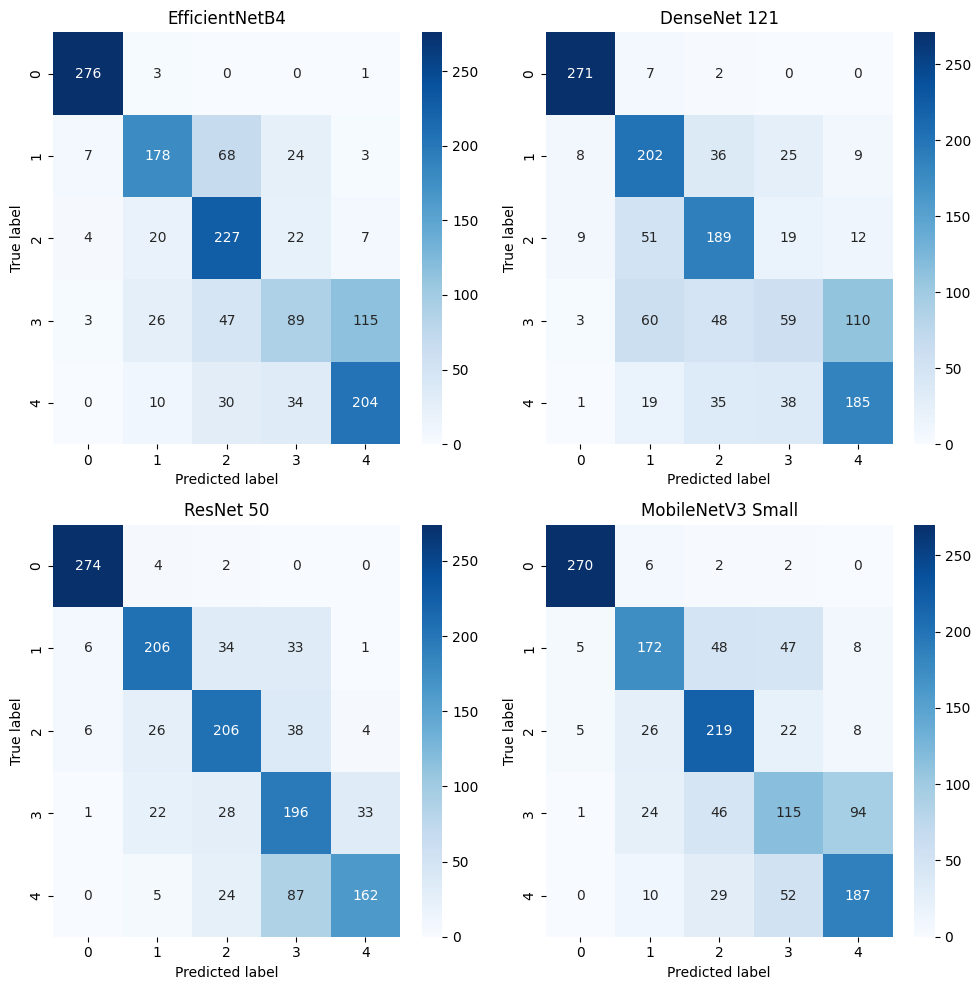

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax, cm, model_name in zip(axs.flatten(), cms, models_names):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

# Choosing the Best Model

In [59]:
resnet=trained_models[2]

In [60]:
resnet.save('/kaggle/working/resnet.h5')